### Your Turn! Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method (we are not using build-in data anymore!)
2. You have to plan on how you will split a data.
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [1]:
import keras
from PIL import Image
import matplotlib.pyplot as plt 
import cv2
import glob
import os
import numpy as np
import sys
import keras

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [47]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    
    # Show report
    print(confusion_matrix(labels.argmax(axis=1),pred_class))
    print(classification_report(labels.argmax(axis=1),pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
#     false_pred = np.asarray(false_pred)
    print(false_pred.shape)
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(6,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(6):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap=plt.cm.binary)
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

# Importing Dataset

In [3]:
from sklearn.model_selection import train_test_split
IMG_W = 200
IMG_H = 200
def read_image(file_path):
    image = cv2.imread(file_path, 1)
    return cv2.resize(image, (IMG_W, IMG_H), interpolation=cv2.INTER_CUBIC)


def load_dataset(datasetPercent):
    train_dogs =   ['dataset/dog/'+filename for filename in os.listdir('dataset/dog') if 'dog' in filename]
    train_cats =   ['dataset/cat/'+filename for filename in os.listdir('dataset/cat') if 'cat' in filename]
    train_image_path = train_cats[:int(len(train_cats)*datasetPercent)] + train_dogs[:int(len(train_dogs)*datasetPercent)]
    
    del train_dogs
    del train_cats
    train_labels = []
    
    data = []
    count = len(train_image_path)
    for i,file_path in enumerate(train_image_path):
        if 'dog' in file_path:
            train_labels.append(0)
        if 'cat' in file_path:
            train_labels.append(1)
        img = read_image(file_path)
        data.append(img)
        if i % (count/10) == 0:
            sys.stdout.write('\r'+"Processed : %d/%d" % (i,count))
    sys.stdout.write('\r'+"Processed : %d/%d            "% (count,count))
    
    X_train, X_test, y_train, y_test = train_test_split(data, train_labels, test_size=0.1, random_state=42)
    del data, train_labels
    sys.stdout.write('\r'+"Done              ")
    return (np.asarray(X_train) , np.asanyarray(y_train)),(np.asanyarray(X_test),np.asanyarray(y_test))

In [4]:
(ani_train_images,ani_train_labels),(ani_test_images,ani_test_labels) = load_dataset(1)

Processed : 25000/25000            

In [5]:
print("Train")
print("Length\ntrain_image: %d \ntrain_labels: %d\n" %(len(ani_train_images), len(ani_train_labels)))
print("Type\ntrain_image:%s\ntrain_label:%s\n"%(type(ani_train_images),type(ani_train_labels)))
print("Shape\ntrain_image:%s\ntrain_label:%s\n" %(ani_train_images.shape,ani_train_labels.shape))
print("===========================================")
print("Test")
print("Length\ntest_image: %d \ntest_labels: %d\n" %(len(ani_test_images), len(ani_test_labels)))
print("Type\ntest_image:%s\ntest_label:%s\n"%(type(ani_test_images),type(ani_test_labels)))
print("Shape\ntest_image:%s\ntest_label:%s\n" %(ani_test_images.shape,ani_test_labels.shape))

Train
Length
train_image: 22500 
train_labels: 22500

Type
train_image:<class 'numpy.ndarray'>
train_label:<class 'numpy.ndarray'>

Shape
train_image:(22500, 200, 200, 3)
train_label:(22500,)

Test
Length
test_image: 2500 
test_labels: 2500

Type
test_image:<class 'numpy.ndarray'>
test_label:<class 'numpy.ndarray'>

Shape
test_image:(2500, 200, 200, 3)
test_label:(2500,)



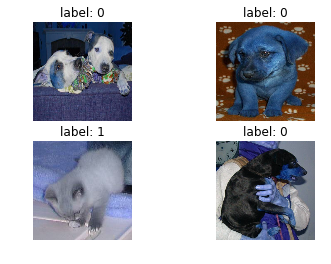

In [6]:
images_and_labels = list(zip(ani_train_images,  ani_train_labels))
for index, (image, label) in enumerate(images_and_labels[12498:12502]):
    plt.subplot(2, 2, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.binary)
    plt.title('label: %s' % label)

In [7]:
print(ani_train_labels[12498:12502])

[0 0 1 0]


# Preprocessing Dataset

In [8]:
from keras.utils import to_categorical
ani_train_images = ani_train_images.reshape(ani_train_images.shape[0], IMG_W, IMG_H , 3).astype('float32')
ani_test_images = ani_test_images.reshape(ani_test_images.shape[0], IMG_W, IMG_H , 3).astype('float32')
ani_train_labels = to_categorical(ani_train_labels)
ani_test_labels = to_categorical(ani_test_labels)

In [9]:
print("Train")
print("Length\ntrain_image: %d \ntrain_labels: %d\n" %(len(ani_train_images), len(ani_train_labels)))
print("Type\ntrain_image:%s\ntrain_label:%s\n"%(type(ani_train_images),type(ani_train_labels)))
print("Shape\ntrain_image:%s\ntrain_label:%s\n" %(ani_train_images.shape,ani_train_labels.shape))
print("===========================================")
print("Test")
print("Length\ntest_image: %d \ntest_labels: %d\n" %(len(ani_test_images), len(ani_test_labels)))
print("Type\ntest_image:%s\ntest_label:%s\n"%(type(ani_test_images),type(ani_test_labels)))
print("Shape\ntest_image:%s\ntest_label:%s\n" %(ani_test_images.shape,ani_test_labels.shape))

Train
Length
train_image: 22500 
train_labels: 22500

Type
train_image:<class 'numpy.ndarray'>
train_label:<class 'numpy.ndarray'>

Shape
train_image:(22500, 200, 200, 3)
train_label:(22500, 2)

Test
Length
test_image: 2500 
test_labels: 2500

Type
test_image:<class 'numpy.ndarray'>
test_label:<class 'numpy.ndarray'>

Shape
test_image:(2500, 200, 200, 3)
test_label:(2500, 2)



# ImportingResnet

In [10]:
modelweight= "pretrained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [11]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(
    weights = modelweight, include_top=False, input_shape=(IMG_H,IMG_W, 3))

In [12]:
#Freeze All Resnet layer
base_model.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Build Model

In [13]:
from keras.models import Sequential
from keras.layers import Dropout,Dense, Dropout,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras import optimizers
from keras import regularizers

# Create the model
ani_model = Sequential()
 
# Add the vgg convolutional base model
ani_model.add(base_model)
 
# Add new layers
ani_model.add(Flatten())
ani_model.add(Dense(1024, activation='relu'))
ani_model.add(Dropout(0.5))
ani_model.add(Dense(IMG_H, activation='relu'))
ani_model.add(Dropout(0.5))
ani_model.add(Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
ani_model.summary()
ani_model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               205000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total para

# Training Model

In [14]:
### Split train and validation data ###
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(ani_train_images, ani_train_labels, test_size=0.1, random_state=42)
del ani_train_images
del ani_train_labels
#######################################

In [15]:
history = ani_model.fit(X_train,y_train,epochs=8,
                   validation_data=(X_val,y_val),
                    batch_size=32,
                    verbose = 1)

Train on 20250 samples, validate on 2250 samples
Epoch 1/8
20250/20250 [==============================] - 146s 7ms/step - loss: 0.2767 - acc: 0.9305 - val_loss: 0.0613 - val_acc: 0.9742
Epoch 2/8
20250/20250 [==============================] - 140s 7ms/step - loss: 0.1379 - acc: 0.9611 - val_loss: 0.1136 - val_acc: 0.9724
Epoch 3/8
20250/20250 [==============================] - 140s 7ms/step - loss: 0.1231 - acc: 0.9658 - val_loss: 0.1530 - val_acc: 0.9631
Epoch 4/8
20250/20250 [==============================] - 140s 7ms/step - loss: 0.1160 - acc: 0.9680 - val_loss: 0.1872 - val_acc: 0.9636
Epoch 5/8
20250/20250 [==============================] - 140s 7ms/step - loss: 0.1118 - acc: 0.9687 - val_loss: 0.1744 - val_acc: 0.9676
Epoch 6/8
20250/20250 [==============================] - 140s 7ms/step - loss: 0.1043 - acc: 0.9719 - val_loss: 0.2225 - val_acc: 0.9684
Epoch 7/8
20250/20250 [==============================] - 140s 7ms/step - loss: 0.0933 - acc: 0.9722 - val_loss: 0.5327 - val_acc:

# Evaluate 

[0.15167429261816132, 0.976]
Last train accuracy: 0.9745185184831973
Last validation accuracy: 0.9751111111111112


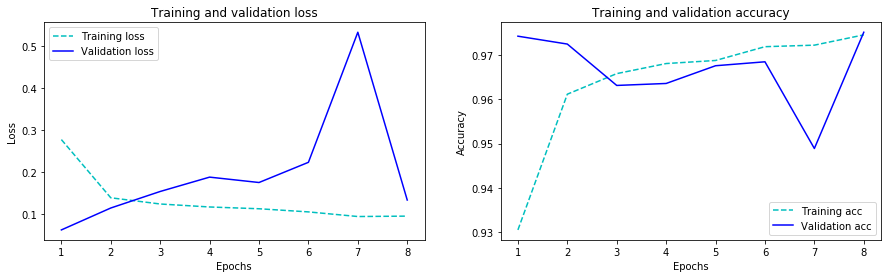

In [17]:
scores = ani_model.evaluate(ani_test_images, ani_test_labels, verbose = 10 )
print ( scores )
###################
show_result(history)
ani_model.save("976percent.h5")

In [19]:
y_pred_ani = evaluation_report(ani_model,ani_test_images,ani_test_labels)

[[1180   22]
 [  38 1260]]
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      1202
          1       0.98      0.97      0.98      1298

avg / total       0.98      0.98      0.98      2500

Loss: 0.15167429261816132 Accuracy: 0.976


(60, 200, 200, 3)
(60, 200, 200, 3)


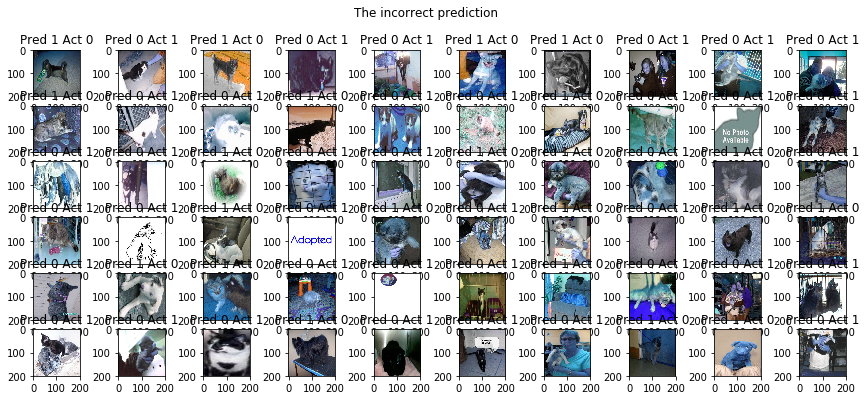

In [48]:
ani_testshow_image = ani_test_images.reshape(ani_test_images.shape[0], IMG_W, IMG_H , 3).astype('int')
show_false_prediction(y_pred_ani, ani_testshow_image, ani_test_labels.argmax(axis=1),200,3)

# show_false_prediction(predict, feature, label, img_size=28, channel=1):

# Use real picture (From Google)

In [16]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import mnist
from keras.models import Sequential
import cv2
import numpy as np
import matplotlib.pyplot as plt
IMG_H = 200
IMG_W = 200

Load Best Model (In last section)

In [2]:
ani_model = models.load_model('976percent.h5')

D:\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [29]:
def load_realdata(file_path):
    image = cv2.imread(file_path, 1)
    return cv2.resize(image, (IMG_W, IMG_H), interpolation=cv2.INTER_CUBIC)

In [30]:
def predictCatDog(model,file_path):
    inImage = load_realdata(file_path)
    plt.imshow(inImage, cmap=plt.cm.binary)
    y_pred = model.predict(inImage.reshape(1,200,200,3).astype('float32'))
    out_pred = y_pred.tolist()[0]
#     print(str(int(out_pred[0])) + " " + str(int(out_pred[1])))
    print(str((out_pred[0])) + " " + str((out_pred[1])))
    
    if int(out_pred[1]) > 0.5 and  int(out_pred[1]) <= 1:
        print('cat')
    else:
        print('dog')
    

1.1969365942832155e-08 1.0
cat


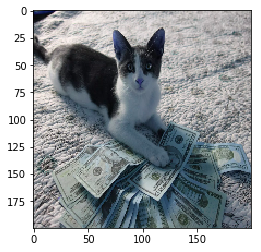

In [31]:
# realpic = load_realdata("realdata/cat/cat.5.jpg")
# realpic = load_realdata("realdata/dog/dog.5.jpg")
# realpic = load_realdata("Realcase/cat.1.jpg")
# plt.imshow(realpic, cmap=plt.cm.binary)?
predictCatDog(ani_model,"Realcase/cat.1.jpg")

2.5276125525833075e-14 1.0
cat


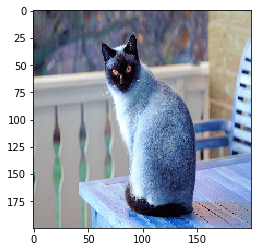

In [32]:
predictCatDog(ani_model,"Realcase/cat.2.jpg")

3.1471069388376716e-24 1.0
cat


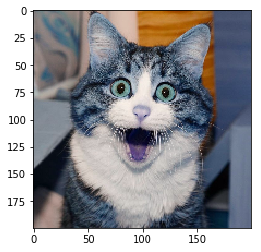

In [33]:
predictCatDog(ani_model,"Realcase/cat.3.jpg")

4.7894918828400327e-17 1.0
cat


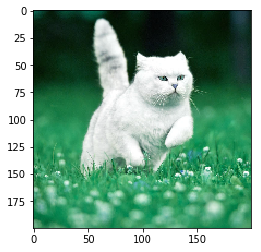

In [34]:
predictCatDog(ani_model,"Realcase/cat.4.jpg")

2.383246551496132e-11 1.0
cat


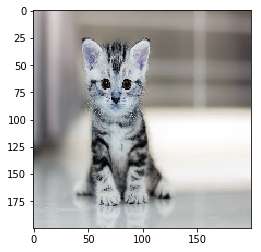

In [35]:
predictCatDog(ani_model,"Realcase/cat.5.jpg")

1.0 5.541661084478034e-25
dog


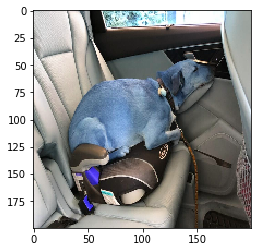

In [36]:
predictCatDog(ani_model,"Realcase/dog.1.jpg")

0.9923116564750671 0.007688342127948999
dog


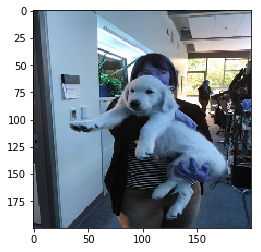

In [37]:
predictCatDog(ani_model,"Realcase/dog.2.jpg")

1.0 2.0342392766080234e-21
dog


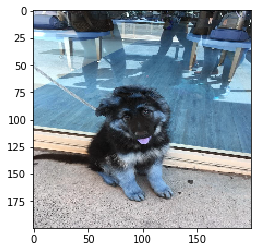

In [38]:
predictCatDog(ani_model,"Realcase/dog.3.jpg")

0.9938422441482544 0.006157702766358852
dog


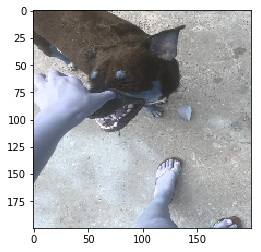

In [39]:
predictCatDog(ani_model,"Realcase/dog.4.jpg")

1.0 5.718097054532601e-32
dog


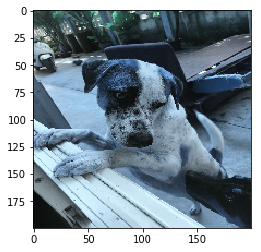

In [40]:
predictCatDog(ani_model,"Realcase/dog.5.jpg")

1.0 5.773085284364526e-33
dog


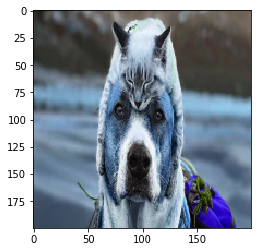

In [41]:
predictCatDog(ani_model,"Realcase/dog.6.jpg")

1.55383695528144e-05 0.9999845027923584
dog


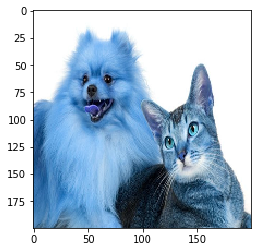

In [42]:
predictCatDog(ani_model,"Realcase/Test.jpg")

5.5783746710070195e-25 1.0
cat


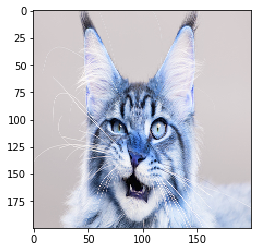

In [43]:
predictCatDog(ani_model,"Realcase/cat.6.jpg")

Reference site: https://www.kaggle.com/jhashanku007/cat-vs-dog-cnn-with-different-pre-trained-model